# Bathymetric data

[*GEBCO Compilation Group (2020) GEBCO 2020 Grid (doi:10.5285/a29c5465-b138-234d-e053-6c86abc040b9*)](https://www.gebco.net/data_and_products/gridded_bathymetry_data/)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')
import xarray

In [2]:
ds = xarray.open_dataset("../tests/testdata/gebco_2020_n56.3_s55.2_w12.2_e13.1.nc")
ds

<xarray.Dataset>
Dimensions:    (lat: 264, lon: 216)
Coordinates:
  * lat        (lat) float64 55.2 55.21 55.21 55.21 ... 56.29 56.29 56.29 56.3
  * lon        (lon) float64 12.2 12.21 12.21 12.21 ... 13.09 13.09 13.09 13.1
Data variables:
    elevation  (lat, lon) int16 ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2020 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The GEBCO_2020 Grid is the latest global bathymetric produc...
    history:      Information on the development of the data set and the sour...
    references:   DOI: 10.5285/a29c5465-b138-234d-e053-6c86abc040b9
    comment:      The data in the GEBCO_2020 Grid should not be used for navi...
    node_offset:  1.0

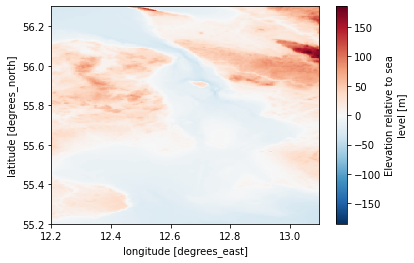

In [3]:
ds.elevation.plot()

In [4]:
ds.elevation.sel(lon=12.74792, lat=55.865, method="nearest")

<xarray.DataArray 'elevation' ()>
array(-43, dtype=int16)
Coordinates:
    lat      float64 55.86
    lon      float64 12.75
Attributes:
    standard_name:       height_above_reference_ellipsoid
    long_name:           Elevation relative to sea level
    units:               m
    sdn_parameter_urn:   SDN:P01::BATHHGHT
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

In [5]:
el = ds.elevation.values
el = np.flipud(el)
el.shape

(264, 216)

Dfs2 need a time dimension even if it only has a single timestep.

In [6]:
el = np.expand_dims(el,axis=0)


Set land values to missing values

In [7]:
el = el.astype('float32')
el[el > 0.0] = np.nan

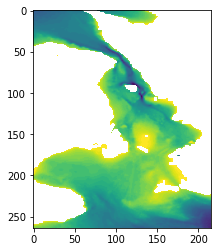

In [8]:
import matplotlib.pyplot as plt
plt.imshow(el[0])

# Coordinates

In [9]:
lat = ds.lat.values
lon = ds.lon.values


nx = len(lon)
ny = len(lat)

dx = (lon[-1] - lon[0]) / (nx-1)
dy = (lat[-1] - lat[0]) / (ny-1)

x0 = lon[0]
y0 = lat[0]


x0, y0, nx, ny, dx, dy

(12.20208333333332,
 55.20208333333332,
 216,
 264,
 0.004166666666666711,
 0.00416666666666666)

# Create dfs2


In [10]:
from mikeio.eum import EUMType, EUMUnit

from mikeio import Dfs2
from mikeio.eum import ItemInfo

d = []
d.append(el)

dfsfilename = "gebco_sound.dfs2"

coordinate = ['LONG/LAT', x0, y0, 0]

dfs = Dfs2()
dfs.write(filename=dfsfilename,
           data=d,
           coordinate=coordinate, dx=dx, dy=dy,
           items=[ItemInfo("Elevation", EUMType.Total_Water_Depth)]
)

c:\users\jan\code\mikeio\mikeio\dfs.py:278: UserWarning: No start time supplied. Using current time: 2021-11-18 13:51:53.515844 as start time.
  warnings.warn(
c:\users\jan\code\mikeio\mikeio\dfs.py:291: UserWarning: No timestep supplied. Using 1s.
  warnings.warn("No timestep supplied. Using 1s.")


# Read the file

In [11]:
newdfs = Dfs2(dfsfilename)
newdfs

<mikeio.Dfs2>
dx: 0.00417
dy: 0.00417
Items:
  0:  Elevation <Total Water Depth> (meter)
Time: time-invariant file (1 step)

In [12]:

newds = newdfs.read()

newds

<mikeio.Dataset>
Dimensions: (1, 264, 216)
Time: 2021-11-18 13:51:53 - 2021-11-18 13:51:53
Items:
  0:  Elevation <Total Water Depth> (meter)

Text(0, 0.5, 'Latitude')

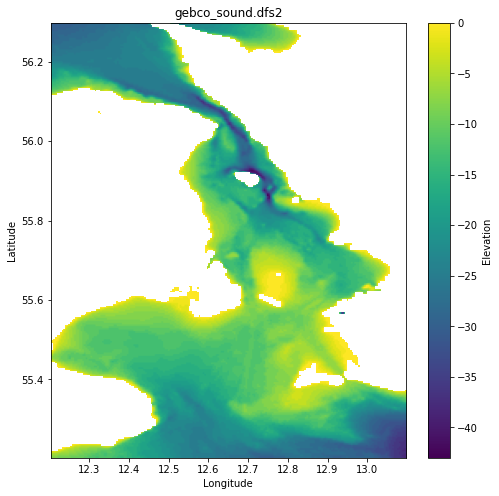

In [20]:
ax = newdfs.plot(newds, title=dfsfilename, label=newds.items[0].name, figsize=(8,8))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

Find index of the deepest point (55.865N, 12.74792E)

In [14]:
k,j = newdfs.find_nearest_element(lon=12.74792,lat=55.865)
print(k,j)

104 131


c:\users\jan\code\mikeio\mikeio\dfs2.py:70: UserWarning: OBSOLETE! method name changed to find_nearest_elements
  warnings.warn("OBSOLETE! method name changed to find_nearest_elements")


In [15]:
newds.data[0][0,k,j]

-43.0

# Clean up

In [16]:
import os
os.remove(dfsfilename)